In [11]:
%matplotlib inline
from scanner import Scanner
from skimage import io, color, util, filters
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from PIL import Image
from bresenham import Bresenham
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pydicom
import numpy as np
import math
import tempfile
import datetime
import scipy.signal

# Setupowanie zmiennych:
detectors = 200
step = 0.01
angle_spread = math.pi
photo = './img/alicjaKot.dcm'
filtering = False

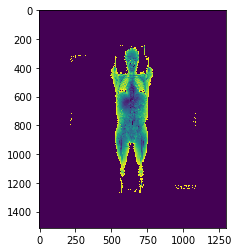

In [12]:
def normalize(num, bot, top):
    if num > top:
        return 1
    if num < bot:
        return 0
    return (num - bot)/(top - bot)


def normalize_photo(photo):
    bot, top = np.percentile(photo, (2, 90))
    print(bot, top)
    res = [[normalize(num, bot, top) for num in x] for x in photo]
    return res

img = None

if(photo[-4:] == '.dcm'):
    dcm_data = None
    with open(photo, 'rb') as infile:
        dcm_data = pydicom.dcmread(infile)
    img = dcm_data.pixel_array
else:
    img = io.imread(photo)

img = color.rgb2gray(img)

plt.imshow(img)
plt.show()

0.0 6832.133200532515


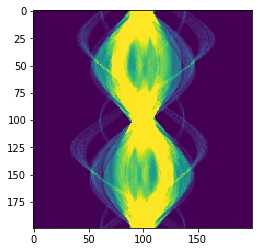

In [13]:
scan = Scanner(img, Bresenham).to_square_img()
scan.set_sampling_params(step, angle_spread, detectors)
sinogram = normalize_photo(scan.generate_sinogram())
plt.imshow(sinogram)
plt.show()

In [14]:
def kernel_function(x):
    if x == 0:
        return 1
    elif x % 2 == 0:
        return 0
    else:
        return (-4/math.pi**2)/(x**2)
    
if filtering:
    kernel = list(map(kernel_function, range(-3, 4)))
    kernel = np.convolve(scipy.signal.windows.flattop(8), kernel)
    scan.filter_samples(kernel)

0.0 97348.15768373033


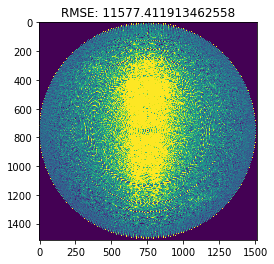

In [15]:
inversed_photo = scan.inverse_radon_transform()
inversed_photo = normalize_photo(inversed_photo)
plt.title('RMSE: ' + str(mean_squared_error(inversed_photo, scan.image)**0.5))
plt.imshow(inversed_photo)
plt.show()

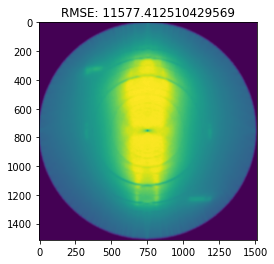

In [16]:
filtered_photo = filters.gaussian(np.array(inversed_photo), 6)
plt.title('RMSE: ' + str(mean_squared_error(filtered_photo, scan.image)**0.5))
plt.imshow(filtered_photo)
plt.show()

In [17]:
def plot_transform(steps):
    sinogram = normalize_photo(scan.generate_sinogram(steps=steps))
    plt.imshow(sinogram)
    plt.show()
    
    inversed_photo = scan.inverse_radon_transform(steps)
    inversed_photo = normalize_photo(inversed_photo)
    filtered_photo = filters.gaussian(np.array(inversed_photo), 6)
    plt.title('RMSE: ' + str(mean_squared_error(filtered_photo, scan.image)**0.5))
    plt.imshow(filtered_photo)
    plt.show()


In [18]:
interact(plot_transform, steps=widgets.IntSlider(min=1, max=scan.emitters_number, step=1, value=scan.emitters_number//2))

interactive(children=(IntSlider(value=99, description='steps', max=199, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_transform(steps)>

In [9]:
sinogram = np.array(sinogram)

#Meta info
meta = pydicom.Dataset()
meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
meta.MediaStorageSOPInstanceUID = "1.2.3"
meta.ImplementationClassUID = "1.2.3.4"

ds2 = pydicom.FileDataset("out.dcm", {}, file_meta=meta, preamble=b"\0" * 128)

out = sinogram * 255
out = out.astype('uint16')

# Tutaj wprowadź dane pacjenta
ds2.PatientName = "Michał Nowak"
ds2.PatientID = "123125"
ds2.PatientSex = "M"
ds2.PatientAge = "35"
ds2.PatientWeight = "92"
ds2.PixelData = Image.fromarray(out).tobytes()
ds2.ImageComment = "Przekrój głowy"

# Ustawianie daty badania na teraz i zapis do pliku
dt = datetime.datetime.now()
ds2.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')
ds2.ContentTime = timeStr
ds2.is_little_endian = True
ds2.is_implicit_VR = True
ds2.BitsAllocated = 16
ds2.Rows = sinogram.shape[0]
ds2.Columns = sinogram.shape[1]
ds2.PixelRepresentation = 0
ds2.SamplesPerPixel = 1
ds2.PhotometricInterpretation = "MONOCHROME2"
ds2.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian

ds2.save_as("out.dcm")

print("Saved sinogram to file.")

Saved sinogram to file.


C:\Users\Ja\conda\lib\site-packages\pydicom\charset.py:513: UserWarning: Failed to encode value with encodings: iso8859 - using replacement characters in encoded string
  .format(', '.join(encodings)))
